In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb

In [2]:
path = Path('./data/')

In [3]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(384)],
        batch_tfms=aug_transforms(mult=1.5, size=384, min_scale=0.75))

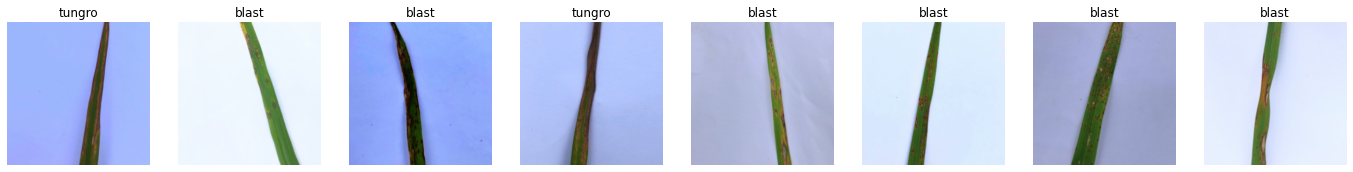

In [4]:
dls = block.dataloaders(path, bs=8)
dls.train.show_batch(max_n=8, nrows=1)

In [5]:
from timm import create_model
import timm
timm.list_models('*mobile*', pretrained=True)

['mobilenetv2_050',
 'mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_100',
 'mobilenetv3_large_100_miil',
 'mobilenetv3_large_100_miil_in21k',
 'mobilenetv3_rw',
 'mobilenetv3_small_050',
 'mobilenetv3_small_075',
 'mobilenetv3_small_100',
 'mobilevit_s',
 'mobilevit_xs',
 'mobilevit_xxs',
 'tf_mobilenetv3_large_075',
 'tf_mobilenetv3_large_100',
 'tf_mobilenetv3_large_minimal_100',
 'tf_mobilenetv3_small_075',
 'tf_mobilenetv3_small_100',
 'tf_mobilenetv3_small_minimal_100']

In [12]:
model = create_model('mobilevit_s', pretrained=True, num_classes=dls.c)
learn = Learner(dls, model, metrics=accuracy, loss_func=LabelSmoothingCrossEntropyFlat())

SuggestedLRs(valley=0.0002754228771664202)

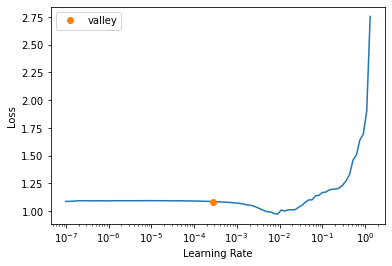

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.046396,0.948548,0.958333,00:09


Better model found at epoch 0 with valid_loss value: 0.9485482573509216.


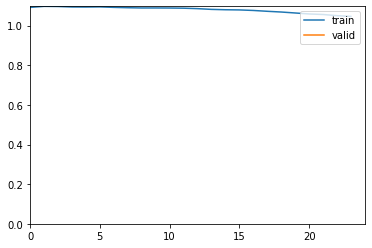

epoch,train_loss,valid_loss,accuracy,time
0,0.886664,0.840501,0.937500,00:10
1,0.802558,0.663027,0.937500,00:09
2,0.690970,0.484744,0.958333,00:09
3,0.625138,0.435626,0.979167,00:09
4,0.563751,0.377589,0.979167,00:09
5,0.489571,0.353911,0.979167,00:09
6,0.472162,0.355558,0.979167,00:09
7,0.438944,0.354416,0.979167,00:09
8,0.432557,0.339893,0.979167,00:09
9,0.416827,0.343304,0.979167,00:09


Better model found at epoch 0 with valid_loss value: 0.8405008316040039.


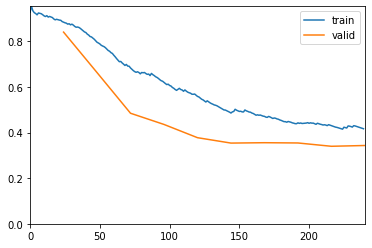

Better model found at epoch 1 with valid_loss value: 0.6630268096923828.
Better model found at epoch 2 with valid_loss value: 0.48474419116973877.
Better model found at epoch 3 with valid_loss value: 0.43562594056129456.
Better model found at epoch 4 with valid_loss value: 0.37758874893188477.
Better model found at epoch 5 with valid_loss value: 0.3539113700389862.
Better model found at epoch 8 with valid_loss value: 0.3398926258087158.



accuracy,▄▁▁▄███████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▆█▂▂▂▂▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
mom_0,█▇▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇████
raw_loss,███▇▆▆▇▅▅▅▄▄▄▃▄▂▃▃▄▂▆▁▁▂▁▁▃▁▃▄▁▂▂▃▂▃▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████▆▆▆▆▆▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▅▃▂▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.97917


In [13]:
with wandb.init(project="leaf-disease-blogpost", name="mobilevit_s"):
    learn.fine_tune(10, 3e-4, freeze_epochs=1, cbs=[WandbCallback(log_preds=False), SaveModelCallback(), ShowGraphCallback()])

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl=dls.train)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=6)

In [ ]:
learn.load("model")
learn.export("models/learner.pkl")